In [12]:
import gzip
import numpy as np
from tinygrad import Tensor, dtypes
from tinygrad.helpers import fetch

def fetch_mnist():
  BASE_URL = 'http://yann.lecun.com/exdb/mnist/'
  parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
  X_train = parse(fetch(f"{BASE_URL}train-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  X_test = parse(fetch(f"{BASE_URL}t10k-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  return Tensor(X_train), Tensor(X_test)

X_train, X_test = fetch_mnist()

In [13]:
from tinygrad import Tensor, nn
lat_v_size = 64
img_size = 28*28
class Encoder():
    def __init__(self):
        self.l1 = nn.Linear(img_size, lat_v_size)
    def __call__(self, x):
        x = self.l1(x)
        return x

class Decoder():
    def __init__(self):
        self.l1 = nn.Linear(lat_v_size, img_size)
        
    def __call__(self, x):
        x = self.l1(x)
        return x

In [14]:
def mse_loss(pred:Tensor, truth:Tensor, normalize=True)->Tensor:
    assert pred.shape == truth.shape
    if normalize: pred, truth = pred/255.0, truth/255.0
    sq_diff = (pred - truth)**2
    return sq_diff.mean()

In [15]:
def test_model(encoder, decoder):
    test_batch = Tensor(X_test.numpy(), requires_grad=False)
    encoded_test = encoder(test_batch)
    decoded_test = decoder(encoded_test)
    return mse_loss(decoded_test, test_batch).numpy()

In [30]:
from tinygrad.helpers import Timing
from tinygrad.nn.optim import SGD, Adam
from tinygrad.nn.state import get_parameters

total_no_train_images = 280000

batch_size = 64
n_steps = total_no_train_images // batch_size
log_interv = n_steps // 64

print("Starting training...")
print(f"Total number of images: {total_no_train_images}")
print(f"batch Size: {batch_size}")
print(f"number of steps: {n_steps}")
print(f"log interval: {log_interv}")

learning_rates = (1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50)
loss_curves = []
for lr in learning_rates:
    encoder = Encoder()
    decoder = Decoder()
    params = get_parameters(encoder) + get_parameters(decoder)
    opt = SGD(params, lr=lr)
    
    test_losses = [] 
    print(f"Training with learning rate: {lr}")
    with Tensor.train(), Timing("Training time: "):
        for step in range(n_steps):
            if step % log_interv == 0:
                test_losses.append(test_model(encoder, decoder))
                
            samp = np.random.randint(0, X_train.shape[0], size=(batch_size)).tolist()
            batch = Tensor(X_train[samp].numpy(), requires_grad=False)
    
            lat_v = encoder(batch)
            out = decoder(lat_v)
            loss = mse_loss(out, batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_losses.append(loss.numpy())
    test_losses.append(test_model(encoder, decoder))
    loss_curves.append(test_losses)


Starting training...
Total number of images: 280000
batch Size: 64
number of steps: 4375
log interval: 68
Training with learning rate: 10
Training time: 431260.74 ms
Training with learning rate: 50
Training time: 519803.27 ms


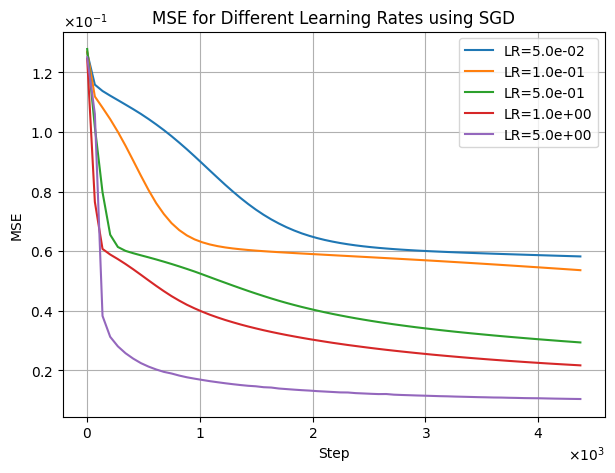

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(7, 5))
test_steps = [step for step in range(0, n_steps, log_interv)] + [n_steps - 1]

for lr, test_losses in zip(learning_rates[-7:-2], loss_curves[-7:-2]):
    plt.plot(test_steps, test_losses, label=f'LR={lr:.1e}')

plt.title('MSE for Different Learning Rates using SGD')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend()
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.grid(True, which="both", ls="-")
plt.show()
